In [6]:
from netCDF4 import Dataset,num2date 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import time
import xarray as xr
import utm
import openpyxl
import pandas as pd
import json
import re
import math

In [7]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'S' or direction == 'W':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])
    lng = dms2dd(parts[4], parts[5], parts[6], parts[7])

    return (lat, lng)

## Wells from NPD

In [12]:
wb = openpyxl.load_workbook(filename = 'Export.xlsx')
ws = wb['Wellbores, all']

from itertools import islice
data = ws.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df = pd.DataFrame(data, index=idx, columns=cols)

#%%
df.set_index(df['OBJECTID'],inplace=True)
cols=['NS UTM [m]','EW UTM [m]','NS degrees','NS minutes','NS seconds','EW degrees','EW minutes','EW seconds','NS decimal degrees','EW decimal degrees','UTM zone','EW code','NS code','Water depth [m]','Well name']
wells=df[cols].to_xarray()
well_utm=df[['NS UTM [m]','EW UTM [m]']].to_xarray()

In [13]:
Earr=[]
Narr=[]
for ii in wells.OBJECTID.values:
    tmp=wells.sel(OBJECTID=ii)
    tmpN=dms2dd(tmp['NS degrees'], tmp['NS minutes'], tmp['NS seconds'], tmp['NS code'])
    tmpE=dms2dd(tmp['EW degrees'], tmp['EW minutes'], tmp['EW seconds'], 'E')
    print('ii',ii,'tmpN',tmpN,'tmpE', tmpE, 'utm',utm.from_latlon(tmpN,tmpE))
   
    E,N,_,_=utm.from_latlon(tmpN,tmpE)
    Earr.append(E)
    Narr.append(N)



ii 33 tmpN 62.184444444444445 tmpE 5.448888888888889 utm (315194.669670284, 6899795.3094265945, 32, 'V')
ii 34 tmpN 60.6325 tmpE 5.471388888888889 utm (307014.5914824476, 6727036.007971283, 32, 'V')
ii 104 tmpN 60.635555555555555 tmpE 4.382777777777777 utm (247559.73538309478, 6731066.788999934, 32, 'V')
ii 126 tmpN 62.26888888888889 tmpE 4.061388888888889 utm (243791.69631673663, 6913917.592322665, 32, 'V')
ii 403 tmpN 60.78472222222222 tmpE 4.365555555555556 utm (247791.81208512755, 6747718.866565937, 32, 'V')
ii 497 tmpN 62.184444444444445 tmpE 5.448888888888889 utm (315194.669670284, 6899795.3094265945, 32, 'V')
ii 2627 tmpN 60.77194444444444 tmpE 4.168611111111111 utm (236982.29924482637, 6747071.860851002, 32, 'V')
ii 5036 tmpN 61.581944444444446 tmpE 4.343333333333333 utm (252910.03304652357, 6836447.908906315, 32, 'V')
ii 8064 tmpN 61.53777777777778 tmpE 4.650833333333334 utm (268880.1663831347, 6830406.874177624, 32, 'V')
ii 8090 tmpN 61.54416666666667 tmpE 4.375277777777778 u

In [137]:
 lat=[]
 lng=[]
 x_utm=[]
 y_utm=[]
 for ii in wells.OBJECTID.values:
   tmp=wells.sel(OBJECTID=ii)
   EW=tmp["EW UTM [m]"]
   if int(math.log10(EW))+1 == 8:
      EW=EW/100
   else:
      EW=EW/10
   
   NS=tmp["NS UTM [m]"]
   if int(math.log10(NS))+1 == 9:
      NS=NS/100
   else:
      NS=NS/10

   _lat,_lng=utm.to_latlon(EW,NS,31,northern=True)

   x_utm.append(EW)
   y_utm.append(NS)
   lat.append(_lat)
   lng.append(_lng)


In [138]:

xarr=xr.Dataset(
    data_vars=dict(
    lat=(["num"], lat),
    lon=(["num"], lng),
    x=(["num"], x_utm),
    y=(["num"], y_utm)
    )
    )

xarr

<xarray.Dataset>
Dimensions:  (num: 10)
Dimensions without coordinates: num
Data variables:
    lat      (num) float64 60.58 60.5 60.62 60.7 ... 60.72 60.78 60.51 60.51
    lon      (num) float64 3.916 3.998 3.806 3.935 ... 4.077 4.334 4.155 4.152
    x        (num) float64 5.502e+05 5.548e+05 5.441e+05 ... 5.634e+05 5.633e+05
    y        (num) float64 6.717e+06 6.708e+06 6.721e+06 ... 6.709e+06 6.709e+06

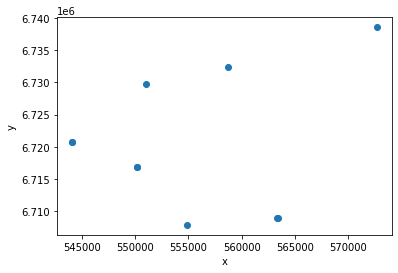

In [26]:
xarr.plot.scatter(x='x',y='y')

In [142]:
with open('leak_coordinates.txt') as f:
#    w, h = [float(x) for x in next(f).split()] # read first line
    E = []
    N=[]
    lat=[]
    lon=[]
    for line in f: # read rest of lines
       e,w=  [float(x) for x in line.split()]
       E.append(e)
       N.append(w)
       _lat,_lon=utm.to_latlon(e,w,31,northern=True)
       lat.append(_lat)
       lon.append(_lon)
       
fault=xr.Dataset(
     data_vars=dict(
         x=(["num"], E),
        y=(["num"], N),
        lat=(["num"],lat),
        lon=(["num"],lon)
    ))
fault


<xarray.Dataset>
Dimensions:  (num: 60)
Dimensions without coordinates: num
Data variables:
    x        (num) float64 5.566e+05 5.568e+05 5.571e+05 ... 5.585e+05 5.585e+05
    y        (num) float64 6.74e+06 6.74e+06 6.739e+06 ... 6.725e+06 6.724e+06
    lat      (num) float64 60.79 60.79 60.79 60.78 ... 60.66 60.65 60.65 60.65
    lon      (num) float64 4.039 4.044 4.049 4.049 ... 4.069 4.069 4.069 4.069

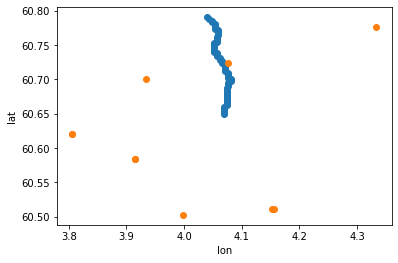

In [143]:

fault.plot.scatter(x='lon',y='lat')
xarr.plot.scatter(x='lon',y='lat')

## Velocities from NorKyst

In [162]:
lat_min=np.minimum(fault.lat.min().values,xarr.lat.min().values)-0.05
lat_max=np.maximum(fault.lat.max().values,xarr.lat.max().values)+0.05
lon_min=np.minimum(fault.lon.min().values,xarr.lon.min().values)-0.1
lon_max=np.maximum(fault.lon.max().values,xarr.lon.max().values)+0.1

xd= xr.open_dataset('https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2018120500.nc')
mask_lon = (xd.lon >= lon_min) & (xd.lon <= lon_max)
mask_lat = (xd.lat >= lat_min) & (xd.lat <= lat_max)
xd.close()
mask=(mask_lon & mask_lat)
tmp=[]
for ii in range(6):
    xd=xr.open_dataset('https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2018120'+str(ii+1)+'00.nc')
    tmp.append(xd.where(mask,drop=True))
    xd.close()
vel=xr.concat(tmp,dim='time')


In [167]:
vel.to_netcdf('ns_vel.nc')

In [168]:
vel

<xarray.Dataset>
Dimensions:                  (time: 144, s_rho: 35, Y: 66, X: 69, depth: 16)
Coordinates:
  * time                     (time) datetime64[ns] 2018-12-01 ... 2018-12-06T...
  * X                        (X) float64 3.12e+05 3.128e+05 ... 3.664e+05
  * Y                        (Y) float64 4.832e+05 4.84e+05 ... 5.352e+05
  * depth                    (depth) float64 0.0 3.0 10.0 ... 1e+03 2e+03 3e+03
    lon                      (Y, X) float64 4.301 4.307 4.313 ... 3.831 3.837
    lat                      (Y, X) float64 60.33 60.33 60.34 ... 60.96 60.96
Dimensions without coordinates: s_rho
Data variables: (12/20)
    Cs_r                     (time, s_rho, Y, X) float64 nan nan nan ... nan nan
    hc                       (time, Y, X) float64 nan nan nan ... nan nan nan
    projection_stere         (time, Y, X) float64 nan nan nan ... nan nan nan
    forecast_reference_time  (time, Y, X) datetime64[ns] NaT NaT NaT ... NaT NaT
    angle                    (time, Y, X) float64 nan nan nan ... nan nan nan
    h                        (time, Y, X) float64 nan nan nan ... nan nan nan
    ...                       ...
    Uwind                    (time, Y, X) float32 nan nan nan ... nan nan nan
    Vwind                    (time, Y, X) float32 nan nan nan ... nan nan nan
    tke                      (time, depth, Y, X) float32 nan nan nan ... nan nan
    vbar                     (time, Y, X) float32 nan nan nan ... nan nan nan
    w                        (time, depth, Y, X) float32 nan nan nan ... nan nan
    AKs                      (time, depth, Y, X) float32 nan nan nan ... nan nan
Attributes: (12/34)
    file:                            /home/metno_op/run/norkyst-800m_2017/oce...
    type:                            ROMS/TOMS history file
    title:                           NorKyst-800m - ROMS
    var_info:                        /home/metno_op/sea/ROMS/metroms/apps/com...
    rst_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    his_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    ...                              ...
    CPP_options:                     NORKYST800M, ADD_FSOBC, ADD_M2OBC, ALBED...
    Conventions:                     CF-1.4, SGRID-0.3
    NCO:                             "4.5.4"
    history:                         Thu Jun 13 13:43:25 2019: ncks -A -v for...
    history_of_appended_files:       Thu Jun 13 13:43:25 2019: Appended file ...
    DODS_EXTRA.Unlimited_Dimension:  time

In [113]:
print(xd.time.max())
print(xd1.time.min())

<xarray.DataArray 'time' ()>
array('2018-12-05T23:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()>
array('2018-12-06T00:00:00.000000000', dtype='datetime64[ns]')


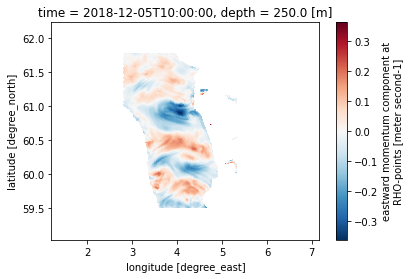

In [95]:
xd_focus.isel(depth=10,s_rho=34,time=10).u_eastward.plot(x='lon',y='lat')

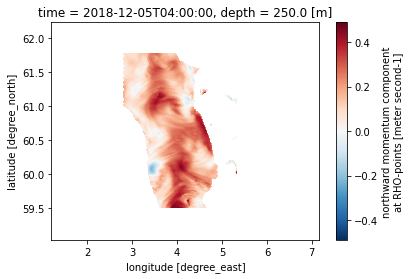

In [96]:
xd_focus.isel(depth=10,s_rho=34,time=4).v_northward.plot(x='lon',y='lat')

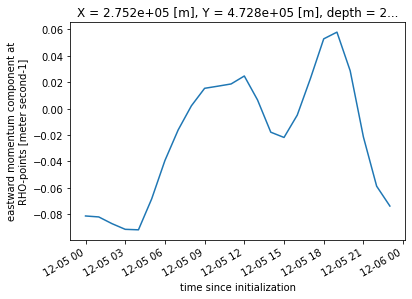

In [106]:
xd_focus.isel(depth=9,s_rho=34,X=100,Y=100).u_eastward.plot()

In [101]:
xd_focus

<xarray.Dataset>
Dimensions:                  (s_rho: 35, Y: 286, X: 358, time: 24, depth: 16)
Coordinates:
  * time                     (time) datetime64[ns] 2018-12-05 ... 2018-12-05T...
  * X                        (X) float64 1.952e+05 1.96e+05 ... 4.808e+05
  * Y                        (Y) float64 3.928e+05 3.936e+05 ... 6.208e+05
  * depth                    (depth) float64 0.0 3.0 10.0 ... 1e+03 2e+03 3e+03
    lon                      (Y, X) float64 4.896 4.902 4.908 ... 3.209 3.215
    lat                      (Y, X) float64 59.04 59.04 59.05 ... 62.21 62.22
Dimensions without coordinates: s_rho
Data variables: (12/20)
    Cs_r                     (s_rho, Y, X) float64 nan nan nan ... nan nan nan
    hc                       (Y, X) float64 nan nan nan nan ... nan nan nan nan
    projection_stere         (Y, X) float64 nan nan nan nan ... nan nan nan nan
    forecast_reference_time  (Y, X) datetime64[ns] NaT NaT NaT ... NaT NaT NaT
    angle                    (Y, X) float64 nan nan nan nan ... nan nan nan nan
    h                        (Y, X) float64 nan nan nan nan ... nan nan nan nan
    ...                       ...
    Uwind                    (time, Y, X) float32 nan nan nan ... nan nan nan
    Vwind                    (time, Y, X) float32 nan nan nan ... nan nan nan
    tke                      (time, depth, Y, X) float32 nan nan nan ... nan nan
    vbar                     (time, Y, X) float32 nan nan nan ... nan nan nan
    w                        (time, depth, Y, X) float32 nan nan nan ... nan nan
    AKs                      (time, depth, Y, X) float32 nan nan nan ... nan nan
Attributes: (12/34)
    file:                            /home/metno_op/run/norkyst-800m_2017/oce...
    type:                            ROMS/TOMS history file
    title:                           NorKyst-800m - ROMS
    var_info:                        /home/metno_op/sea/ROMS/metroms/apps/com...
    rst_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    his_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    ...                              ...
    CPP_options:                     NORKYST800M, ADD_FSOBC, ADD_M2OBC, ALBED...
    Conventions:                     CF-1.4, SGRID-0.3
    NCO:                             "4.5.4"
    history:                         Thu Jun 13 13:45:28 2019: ncks -A -v for...
    history_of_appended_files:       Thu Jun 13 13:45:28 2019: Appended file ...
    DODS_EXTRA.Unlimited_Dimension:  time